In [1]:
import torch

/shared/home/u076079/envs/LSTM_torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [53]:
device

'cuda'

In [4]:
from torchtext.datasets import SQuAD1

In [5]:
train, test = SQuAD1("root")

In [6]:
from modules.data import get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [8]:
train_df = sample_df_perc(train_df, 0.2)

In [9]:
test_df = sample_df_perc(test_df, 0.2)

In [10]:
train_df.shape, test_df.shape

((17519, 2), (2114, 2))

In [11]:
train_df.head()

,Question,Answer
0,How close did von Bellingshausen and Lazarev c...,32 km
1,Where did the New York times report say towers...,the coasts of the British Isles
2,What was the late 16th century war against Hab...,The Long War
3,Who attended the Avery Normal Institute?,Charleston's African American population
4,How does central Catalan behave with the groups?,as an innovative element


In [12]:
import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

When did the Soviet government assume power?
['when', 'soviet', 'government', 'assume', 'power']
['when', 'soviet', 'govern', 'assum', 'power']


# Vocabulary

In [13]:
from modules.vocab import Vocab

## Make pairs to add to the vocabularies. 

#### Only the questions will be normalized (stemmed) but not the answers - otherwise we would get stemmed words in the chatbot answers

In [14]:
for col, norm in zip(cols, ['stem', None]):
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [15]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [16]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
16607,What was amended to provide more office space ...,heritage regulations,"[what, amend, provid, offic, space, downtown]","[heritage, regulations]"
2666,Who was the 13th-century Spanish rabbi and rec...,Nachmanides,"[who, 13thcenturi, spanish, rabbi, recognis, l...",[nachmanides]
10577,"Who had a hit single with ""jack the groove""?",Raze,"[who, hit, singl, jack, groov]",[raze]


In [17]:
test_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
1896,The uniflow engine is an attempt to fix an iss...,counterflow,"[uniflow, engin, attempt, fix, issu, aris, wha...",[counterflow]
1678,"Where are the Harvard medical, Dental and scho...",Longwood Medical and Academic Area,"[where, harvard, medic, dental, school, public...","[longwood, medical, academic, area]"
1292,What items comprise the John Jones Collection?,French 18th-century art and furnishings,"[what, item, compris, john, jone, collect]","[french, 18thcentury, art, furnishings]"


In [18]:
cols_tokens = [f'{col}_tokens' for col in cols]

In [19]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [20]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [21]:
Q_vocab, A_vocab = Vocab(), Vocab()

In [22]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [23]:
Q_vocab.n_words, A_vocab.n_words, 

(13010, 16084)

In [24]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [25]:
Q_vocab.n_words, A_vocab.n_words 

(13879, 17376)

## Functions for some data analysis

In [26]:
from modules.stats import sentences_stats, histograms

In [27]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.45
	         median: 6.00
	         minimum: 1
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 2.43
	         median: 2.00
	         minimum: 0
	         maximum: 22)


In [28]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.56
	         median: 6.00
	         minimum: 2
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.40
	         median: 2.00
	         minimum: 0
	         maximum: 18)


## Remove the least common words from the sentences

In [29]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [30]:
get_outliers(Q_vocab, outlier_threshold+1), get_outliers(A_vocab, outlier_threshold+1)

(['bellingshausen',
  'lazarev',
  'averi',
  'tio',
  'ellina',
  'lycan',
  'conservatori',
  'ye',
  'cock',
  'eldest',
  'magnat',
  '19951996',
  'rockhopp',
  'sealer',
  'creditor',
  'vinegar',
  'epigraph',
  'postral',
  'casco',
  'viejo',
  'bilbao',
  'helvet',
  'rialto',
  'combinatori',
  'mv',
  'marcus',
  'garvey',
  'stron',
  'warlord',
  'baihu',
  'durbarmarg',
  'memior',
  'unteraar',
  'whenev',
  'princesss',
  'kefauverharri',
  '300feet',
  'musket',
  'autopsi',
  'forbad',
  'deloitt',
  'electro',
  '1254',
  'grecoturkish',
  'susanna',
  'thirdhighestrank',
  'signifi',
  'worthi',
  'rutland',
  'maltaburet',
  'sercic',
  'agp',
  'gaseous',
  'gva',
  'tibetologist',
  'berkshir',
  'hathaway',
  'manoa',
  'stimuli',
  'fantast',
  'creationist',
  'gabe',
  'newel',
  'weissenbach',
  'looser',
  'dd',
  'moldova',
  'amistad',
  'codeshar',
  'nonstop',
  'terra',
  'australi',
  'bassa',
  'judean',
  'genitalia',
  'mutil',
  'soga',
  'assiz'

In [31]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [32]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [33]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [34]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.07
	         median: 6.00
	         minimum: 1
	         maximum: 20)
Sentences in column Answer_tokens:
	         mean: 1.88
	         median: 1.00
	         minimum: 0
	         maximum: 19)


# remove questions that have less than three words and answers that have less than 1


## Remove long outliers: long sentences that occure rarely

In [35]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


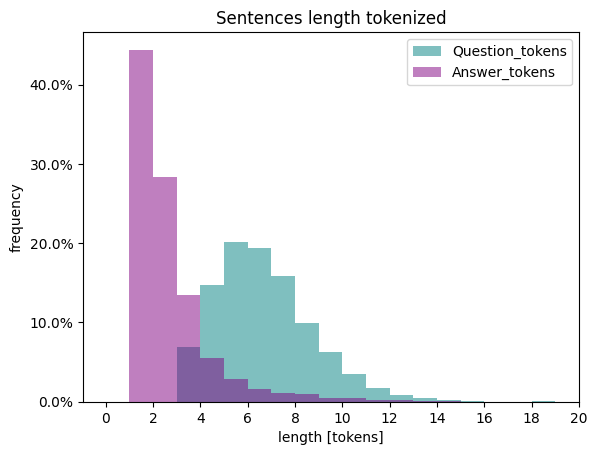

In [36]:
train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [37]:
train_df_final.shape

(14434, 4)

In [38]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.17
	         median: 6.00
	         minimum: 3
	         maximum: 20)
Sentences in column Answer_tokens:
	         mean: 2.21
	         median: 2.00
	         minimum: 1
	         maximum: 19)


In [39]:
# keeping only the 95% of the data

cutoff = 95

In [40]:
# keeping only the 95% of the data

get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [41]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [42]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [43]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.00
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.95
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [44]:
train_df_final.shape

(13438, 4)

# Must make pairs from the dataset with removed short and long sequences

In [45]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [46]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [47]:
len(train_pairs_final), len(test_pairs_final)

(13438, 2114)

# building the model

In [48]:
#from modules.models import Seq2Seq

In [55]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, hidden_size, embedding_size):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size

        #self.hidden = torch.zeros(1, 1, hidden_size)

        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)
        
        # The LSTM is our last cell because it produces the hidden state        
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)
        
        x = x.view(1, 1, -1)
        
        #x = x.view(x.shape[0], 1, -1)
        
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        # The LSTM produces an output by passing the hidden state to the   Linear layer
    
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim= 1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state

    
    

class Seq2Seq(nn.Module):

    #def __init__(self, encoder: Encoder, decoder: Decoder, device: torch.device):
    def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    
        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
        #self.device = device
        
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
        
        max_len, batch_size = trg_batch.shape
                
        trg_vocab_size = self.decoder.output_size
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 

         # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)

        for i in range(src_len):
        
            # last hidden & cell state of the encoder is used as the decoder's initial hidden state
            _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
        
        
        
        trg = trg_batch[0]
        
        for i in range(trg_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

In [50]:
embedding_dim = 256

In [49]:
hidden_size = 256

In [56]:
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

In [57]:
seq2seq = seq2seq.to(device)

In [58]:
from torch import optim
import torch.nn as nn

In [60]:
learning_rate = 0.05
num_epochs = 5

In [61]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

In [71]:
def train(model, pairs, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    
    total_loss = 0

    count = 0
    
    for pair in pairs:
        
        src = pair.question
        tgt = pair.answer
        
        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        # print(src_tensor.shape, tgt_tensor.shape)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=1)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
        count += 1 
    
        if count % 100 == 0:
            print(f'Loss {total_loss/count}')
    
    return total_loss / len(pairs)